In [1]:
import numpy as np
import itertools
import pandas as pd
from sklearn import datasets
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
iris = datasets.load_iris()

In [3]:
data = iris['data']
labels = iris['target']
feature_names = ['_'.join(str(x).split()[:2]) for x in iris['feature_names']]

In [4]:
df = pd.DataFrame(data=np.concatenate([data, labels.reshape(-1, 1)], axis=1),
             columns=feature_names+['label'])
df['label'] = df['label'].astype(int)

Рассмотрим распредление данных для каждого признака и класса ирисов. Скрипочные графики позволяют получить априорное представление о наличии различий в значениях признаков для разных видов и ирисов, а также предположение о нормальности распределения признаков.

Видим, что распределения визуально близки к нормальным, для трех характеристик из четырех имеют место существенные различия в зависимости от вида ириса, для оставшейся характеристики (sepal width) различия существенны, но не настолько. Опять же в трех случаях из четырех виды ирисов под идентификаторами 0 и 2 наиболее различимы.

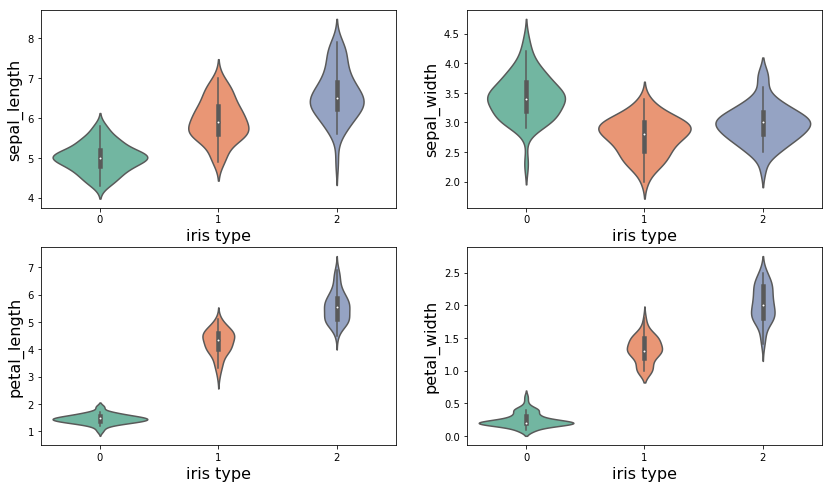

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(14,8))
axs = axs.flatten()
for ax, feat in zip(axs, feature_names):
    violin_plt = sns.violinplot(x="label", y=feat, data=df, ax=ax, palette="Set2", split=True)
    violin_plt.set_xlabel("iris type",fontsize=16)
    violin_plt.set_ylabel(feat, fontsize=16);

Проверяя нормальность с помощью теста Шапиро, приходим к выводу, что данная гипотеза не отклоняется. В дальнейшем рассмотрении задачи допускаем нормальность распределения данных, принимая во внимание результаты данного теста.

In [6]:
for label in np.unique(labels):
    print("iris type: ", label)
    for feat in feature_names:
        x = df[df['label']==label][feat].values
        pval = scipy.stats.shapiro(x)[0]
        print("feature: %s, Shapiro's pval: %.3f"%(feat, pval))
    print("-"*45)

iris type:  0
feature: sepal_length, Shapiro's pval: 0.978
feature: sepal_width, Shapiro's pval: 0.972
feature: petal_length, Shapiro's pval: 0.955
feature: petal_width, Shapiro's pval: 0.800
---------------------------------------------
iris type:  1
feature: sepal_length, Shapiro's pval: 0.978
feature: sepal_width, Shapiro's pval: 0.974
feature: petal_length, Shapiro's pval: 0.966
feature: petal_width, Shapiro's pval: 0.948
---------------------------------------------
iris type:  2
feature: sepal_length, Shapiro's pval: 0.971
feature: sepal_width, Shapiro's pval: 0.967
feature: petal_length, Shapiro's pval: 0.962
feature: petal_width, Shapiro's pval: 0.960
---------------------------------------------


Вычислим среднее различие характеристик между разными видами ирисов.

In [7]:
# get mean values of features for each label
agg_by_label = df.groupby('label').mean()
agg_by_label

,sepal_length,sepal_width,petal_length,petal_width
label,,,,
0,5.006,3.428,1.462,0.246
1,5.936,2.770,4.260,1.326
2,6.588,2.974,5.552,2.026


In [8]:
# compute absolute differences between mean values of features for all labels pairwise
def get_dists(feat):
    uniques = np.unique(labels)
    n = uniques.shape[0]
    dist_matrix = np.zeros((n,n))
    for (i, j) in itertools.product(uniques, repeat=2):
        feat_val = agg_by_label[feat]
        dist_matrix[i, j] = feat_val.loc[i] - feat_val.loc[j]
    return np.abs(dist_matrix)

Следующий график представляет собой попарные средние различия (по молулю) каждого из признаков для разных видов ирисов.

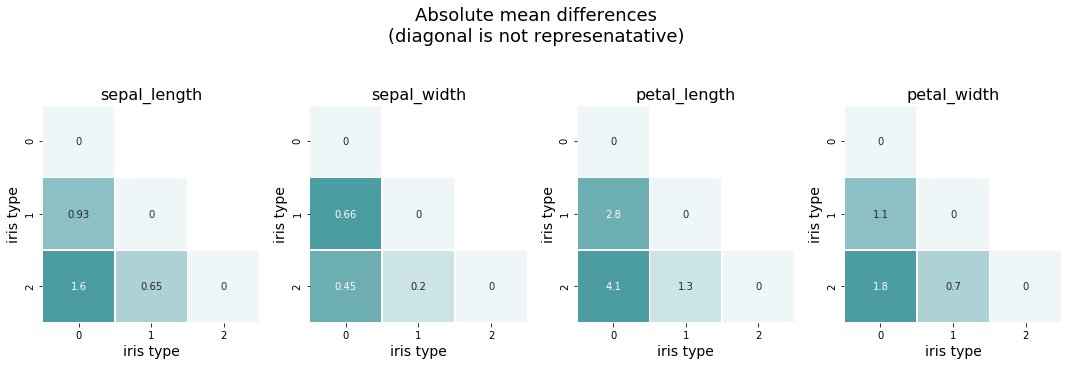

In [9]:
# plot absolute mean differences for all pairs of labels
cmap = sns.light_palette((200, 75, 60), input="husl")
fig, axs = plt.subplots(1, 4, figsize=(15, 6))
plt.suptitle('Absolute mean differences\n(diagonal is not represenatative)', fontsize=18)

for idx, feat in enumerate(agg_by_label.columns):
    dist_matrix = get_dists(feat)
    
    mask = np.zeros_like(dist_matrix, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    mask[np.diag_indices_from(mask)] = False

    sns.heatmap(dist_matrix, mask=mask, cmap=cmap, square=True,\
                linewidths=.5, cbar=False, annot=True, ax=axs[idx]);
    axs[idx].set_title(feat, fontsize=16)
    axs[idx].set_xlabel('iris type', fontsize=14)
    axs[idx].set_ylabel('iris type', fontsize=14)

plt.tight_layout();

Для оценки размера эффекта выберем _Cohen's d_ меру, основываясь на том, что именно она наиболее часта используется в биологических задачах при сравнении популяций. Для классификации размеров по уровням используем стандартное разбиение в зависимости от значения меры. За уровень эффекта принимается наиближайшее значение из сетки.

In [10]:
# compute pairwise effect sizes (cohen's d measure)
def cohens_d(x, y):
    s1 = np.std(x, ddof=1)
    s2 = np.std(y, ddof=1)
    s = np.sqrt(((len(x)-1)*s1**2 + (len(y)-1)*s2**2) / (len(x) + len(y) - 2))
    d = (np.mean(x) - np.mean(y)) / s
    return d


def get_effect_size(feat):
    uniques = np.unique(labels)
    n = uniques.shape[0]
    dist_matrix = np.zeros((n,n))
    feat_df = df[feat]
    for (i, j) in itertools.product(uniques, repeat=2):
        x = feat_df[df['label']==i].values
        y = feat_df[df['label']==j].values
        dist_matrix[i, j] = cohens_d(x, y)
    return np.abs(dist_matrix)


def get_effect_level_annot(dist_matrix):
    # annotation for heatmap
    roulette = np.array([0.01, 0.2, 0.5, 0.8, 1.2, 2.0])
    levels = ['very small', 'small', 'medium', 'large', 'very large', 'huge']
    fn = lambda x: "%.02f\n(%s)"%(x, levels[np.argmin(np.abs(roulette-x))])
    vect_fn = np.vectorize(fn)
    annot = vect_fn(dist_matrix)
    annot[np.diag_indices_from(annot)] = "0"
    return annot

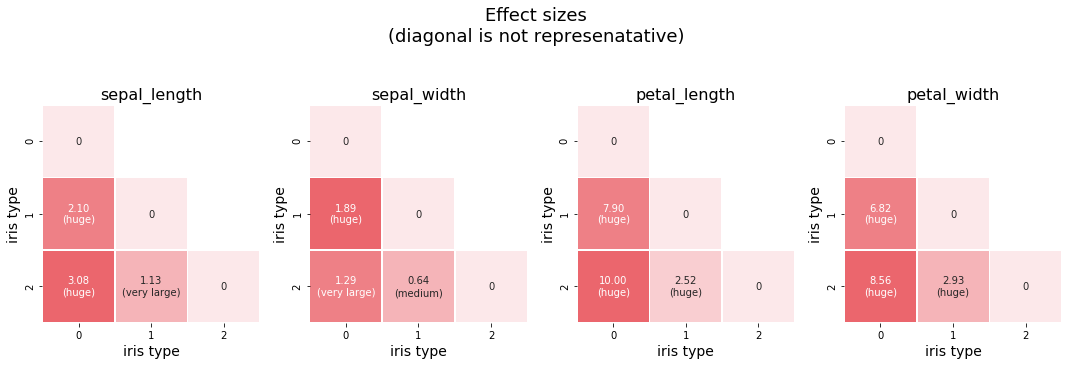

In [11]:
# plot effect sizes for all pairs of labels
cmap = sns.light_palette((10, 75, 60), input="husl")
fig, axs = plt.subplots(1, 4, figsize=(15, 6))
plt.suptitle('Effect sizes\n(diagonal is not represenatative)', fontsize=18)

for idx, feat in enumerate(agg_by_label.columns):
    effect_matrix = get_effect_size(feat)
    annot = get_effect_level_annot(effect_matrix)
    
    mask = np.zeros_like(effect_matrix, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    mask[np.diag_indices_from(mask)] = False

    sns.heatmap(effect_matrix, mask=mask, cmap=cmap, square=True,\
                linewidths=.5, cbar=False, annot=annot, ax=axs[idx], fmt = '');
    axs[idx].set_title(feat, fontsize=16)
    axs[idx].set_xlabel('iris type', fontsize=14)
    axs[idx].set_ylabel('iris type', fontsize=14)

plt.tight_layout();

---
---
Подводя черту, можно утверждать, что графическое представление данных (в данном случае скрипочные графики) дают хорошее априорное представление о имеющихся данных. По построенному графику уже можно было делать первичные выводы о порядковом соотношении исследуемых характеристик, их нормальности и оценочном уровне эффекта. Далее требуемые исследования были проделаны с полной строгостью: проверкой гипотезы нормальности и вычислением меры размера эффекта. Полученные в результате тщательного оценивания результаты согласуется с первичными выводами, сделаннами на основе инфографики.